# Developing scripts for skill assessment

In [2]:
import cartopy
import cartopy.crs as ccrs

cartopy.config["pre_existing_data_dir"] = "../../data/cartopy-data"
cartopy.config["data_dir"] = "../../data/cartopy-data"

import numpy as np
import xarray as xr

from dask.distributed import Client

import matplotlib.pyplot as plt

from src import verify

/g/data/xv83/users/ds0092/software/miniconda3/envs/forecast_analysis/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [3]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

# Run `verify` on a config

In [103]:
config = "../../config/verify/CanESM5.yml"
save_dir = "../../data/skill/"

# with Client(processes=False) as client:
test = verify.verify(config, save_dir=save_dir, save=False)

KeyboardInterrupt: 

# Run `calculate_metric` manually

In [22]:
DATA_DIR = "../../data/processed/"

# EC_Earth3.JRA55.annual.anom_1985-2014.t_ref.CRPSS_1985-2014

hcst = xr.open_zarr(
    "../../data/processed/CAFEf6.annual.anom_1991-2020.precip_global.zarr"
)
obsv = xr.open_zarr(
    "../../data/processed/GPCP.annual.anom_1991-2020.precip_global.zarr/"
)

In [26]:
def _reindex_hindcast(hindcast):
    """
    Reindex hindcast dataset that is indexed by initial date and lead time
    to be indexed by target date and lead time
    """
    result = []
    for lead in hindcast["lead"]:
        hcst = hindcast.sel({"lead": lead}).swap_dims({"init": "time"})
        result.append(hcst)
    return xr.concat(result, dim="lead")


times = slice("1991", "2020")
hcst_verif = _reindex_hindcast(hcst).sel(time=times)
obsv_verif = obsv.sel(time=hcst_verif.time)

In [44]:
test = verify._calculate_metric_from_timeseries(
    hcst_verif,
    obsv_verif,
    metric=verify.msss_clim,
    metric_kwargs={},
    significance=False,
).compute()

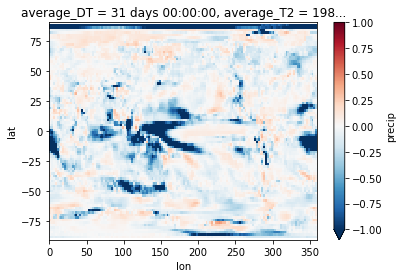

In [48]:
test["precip"].isel(lead=1).plot(vmin=-1, vmax=1, cmap="RdBu_r")

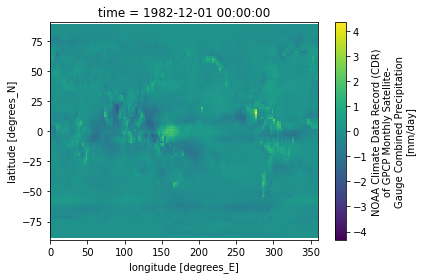

In [15]:
obsv["precip"].isel(time=0).plot(cmap="viridis")

In [42]:
from src import utils

hcst = utils.mask_period(hcst, period=["1991", "2020"])

In [10]:
lead = 0

hcst_ts = hcst.isel(lead=lead).swap_dims({"init": "time"}).dropna("time", how="all")
hist_ts = hist.sel(time=hcst_ts.time)
obsv_ts = obsv.sel(time=hcst_ts.time)

In [11]:
t = verify._calculate_metric_from_timeseries(
    hcst_ts, obsv_ts, hist_ts, metric=verify.msss, metric_kwargs={}, significance=False
)

In [12]:
t["nino34"].values

array(0.78154754)

In [43]:
%%time

a = verify.calculate_metric(
    hcst, 
    obsv,
    hist,
    metric="crpss", 
    significance=False
)

with Client(processes=False) as client:
    a = a.compute()

/g/data/xv83/users/ds0092/active_projects/Squire_2022_CAFE-f6/src/verify.py:542: UserWarning: A common set of verification times at all leads could not be found. Verifying over all available times at each lead
  (


CPU times: user 5.18 s, sys: 146 ms, total: 5.33 s
Wall time: 6.18 s


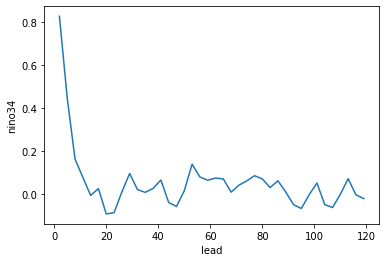

In [44]:
a["nino34"].plot()

In [15]:
import xskillscore as xs

xs.pearson_r()

<function xskillscore.core.deterministic.pearson_r(a, b, dim=None, weights=None, skipna=False, keep_attrs=False)>

# Is it faster to calculate the skill metric within `apply_ufunc`?

In [287]:
n_iterations = 1000

In [290]:
%%time

def mean_error_np(a, b):
    return np.mean(np.mean(a, axis=-1) - b, axis=-1)

bootstraps = [
    bootstrap_metric(
        hindcast_verif_times,
        references_verif_times,
        dim=["time", "member"],
        metric=mean_error_np,
    )
    for _ in range(n_iterations)
]
a = xr.concat(
        bootstraps, dim="iteration", coords="minimal", compat="override"
    )

with Client() as client:
    a = a.compute()

CPU times: user 1min 11s, sys: 9.62 s, total: 1min 20s
Wall time: 1min 19s


In [291]:
%%time

def mean_error(a, b):
    return (a.mean("member") - b).mean("time")

bootstraps = iterative_bootstrap(
    hindcast_verif_times,
    references_verif_times,
    dim=["time", "member"],
    n_iterations=n_iterations,
)

b = mean_error(*bootstraps)

with Client() as client:
    b = b.compute()

CPU times: user 1min 21s, sys: 10.5 s, total: 1min 31s
Wall time: 1min 29s


### Not by an amount that justifies the inconvenience...

# Old versions of bootstrapping functions

### Apply metric within ufunc

In [ ]:
from collections import OrderedDict


def _nested_random_indices(sizes):
    """
    Returns indices to randomly resample (with replacement) an array in a nested
    manner. I.e. randomly resample the first dimension, then for each randomly
    sampled element along that dimension, randomly resample the second dimension,
    then for each randomly sampled element along that dimension, randomly resample
    the third dimension etc.

    Parameters
    ----------
    sizes : OrderedDict
        Dictionary with the names and sizes of the dimensions to resample
    """

    shape = [s for s in sizes.values()]
    indices = OrderedDict()
    for ax, key in enumerate(sizes.keys()):
        indices[key] = np.random.randint(0, shape[ax], shape[: ax + 1])
    return indices


def _expand_nested_random_indices(indices):
    """
    Expand the dimensions of the nested input arrays so that they can be broadcast
    and return a tuple that can be directly indexed

    Parameters
    ----------
    indices : list of numpy arrays
        List of numpy arrays of sequentially increasing dimension as output by the
        function `nested_random_indices`
    """
    broadcast_ndim = indices[-1].ndim
    broadcast_indices = []
    for i, ind in enumerate(indices):
        broadcast_indices.append(
            np.expand_dims(ind, axis=list(range(i + 1, broadcast_ndim)))
        )
    return (..., *tuple(broadcast_indices))


def bootstrap_metric(*objects, dim, metric):
    """
    Bootstrap the provided array across the specified dimension(s) in a nested
    manner. I.e. bootstrap the first provided dimension, then for each
    bootstrapped sample along that dimenion, bootstrap the second provided
    dimension, then for each bootstrapped sample along that dimenion...

    Parameters
    ----------
    objects : iterable of Datasets
        The data to bootstrap. Multiple datasets can be passes to be
        bootstrapped in the same way. Where multiple datasets are passed,
        all datasets need not contain all bootstrapped dimensions. However,
        because of the bootstrapping is applied in a nested manner, the
        dimensions in all input objects must also be nested. E.g., for
        `dim=['d1','d2','d3']` an object with dimensions 'd1' and 'd2' is
        valid but an object with only dimension 'd2' is not.
    dim : str or iterable of str
        The dimension(s) to bootstrap in a nested manner.
    update_outer_dim_coords : boolean, optional
        If True, the index coordinates of the outer (first) dimension in
        dim and any non-index coordinates with this dimension are updated
        to reflect the bootstrap shuffling along that dimension. Otherwise,
        the data are shuffled, but the coordinates are left unchanged.
    """

    def _bootstrap(*arrays, indices, metric):
        """Bootstrap the array(s) using the provided indices"""
        bootstrapped = tuple([array[ind] for array, ind in zip(arrays, indices)])
        metric_bootstrapped = metric(*bootstrapped)
        return metric_bootstrapped

    if isinstance(dim, str):
        dim = [dim]

    # Get the sizes of the bootstrap dimensions
    sizes = None
    for obj in objects:
        try:
            sizes = OrderedDict({d: obj.sizes[d] for d in dim})
            break
        except KeyError:
            pass
    if sizes is None:
        raise ValueError("At least one input object must contain all dimensions in dim")

    # Generate the random indices first so that we can be sure that each
    # dask chunk uses the same indices. Note, I tried using random.seed()
    # to achieve this but it was flaky
    nested_indices = _nested_random_indices(sizes)  # Indices to resample all objects

    # Need to expand the indices for broadcasting for each object separately
    # as each object may have different dimensions
    indices = []
    input_core_dims = []
    for obj in objects:
        available_dims = [d for d in dim if d in obj.dims]
        indices_to_expand = [nested_indices[key] for key in available_dims]

        # Check that dimensions are nested
        ndims = [i.ndim for i in indices_to_expand]
        if ndims != list(range(1, len(ndims) + 1)):
            raise ValueError("The dimensions of all inputs must be nested")

        indices.append(_expand_nested_random_indices(indices_to_expand))
        input_core_dims.append(available_dims)

    return xr.apply_ufunc(
        _bootstrap,
        *objects,
        kwargs=dict(
            indices=indices,
            metric=metric,
        ),
        input_core_dims=input_core_dims,
        output_core_dims=[[]],
        keep_attrs=True,
        dask="parallelized",
        output_dtypes=[float],
    )

### Basic nested bootstrap

In [ ]:
from collections import OrderedDict


def _nested_random_indices(sizes):
    """
    Returns indices to randomly resample (with replacement) an array in a nested
    manner. I.e. randomly resample the first dimension, then for each randomly
    sampled element along that dimension, randomly resample the second dimension,
    then for each randomly sampled element along that dimension, randomly resample
    the third dimension etc.

    Parameters
    ----------
    sizes : OrderedDict
        Dictionary with the names and sizes of the dimensions to resample
    """

    shape = [s for s in sizes.values()]
    indices = OrderedDict()
    for ax, key in enumerate(sizes.keys()):
        indices[key] = np.random.randint(0, shape[ax], shape[: ax + 1])
    return indices


def _expand_nested_random_indices(indices):
    """
    Expand the dimensions of the nested input arrays so that they can be broadcast
    and return a tuple that can be directly indexed

    Parameters
    ----------
    indices : list of numpy arrays
        List of numpy arrays of sequentially increasing dimension as output by the
        function `nested_random_indices`
    """
    broadcast_ndim = indices[-1].ndim
    broadcast_indices = []
    for i, ind in enumerate(indices):
        broadcast_indices.append(
            np.expand_dims(ind, axis=list(range(i + 1, broadcast_ndim)))
        )
    return (..., *tuple(broadcast_indices))


def bootstrap(*objects, dim, update_outer_dim_coords=True):
    """
    Bootstrap the provided array across the specified dimension(s) in a nested
    manner. I.e. bootstrap the first provided dimension, then for each
    bootstrapped sample along that dimenion, bootstrap the second provided
    dimension, then for each bootstrapped sample along that dimenion...

    Parameters
    ----------
    objects : iterable of Datasets
        The data to bootstrap. Multiple datasets can be passes to be
        bootstrapped in the same way. Where multiple datasets are passed,
        all datasets need not contain all bootstrapped dimensions. However,
        because of the bootstrapping is applied in a nested manner, the
        dimensions in all input objects must also be nested. E.g., for
        `dim=['d1','d2','d3']` an object with dimensions 'd1' and 'd2' is
        valid but an object with only dimension 'd2' is not.
    dim : str or iterable of str
        The dimension(s) to bootstrap in a nested manner.
    update_outer_dim_coords : boolean, optional
        If True, the index coordinates of the outer (first) dimension in
        dim and any non-index coordinates with this dimension are updated
        to reflect the bootstrap shuffling along that dimension. Otherwise,
        the data are shuffled, but the coordinates are left unchanged.
    """

    def _bootstrap(*arrays, indices):
        """Bootstrap the array(s) using the provided indices"""
        bootstrapped = tuple([array[ind] for array, ind in zip(arrays, indices)])
        if len(bootstrapped) == 1:
            return bootstrapped[0]
        else:
            return bootstrapped

    if isinstance(dim, str):
        dim = [dim]

    # Get the sizes of the bootstrap dimensions
    sizes = None
    for obj in objects:
        try:
            sizes = OrderedDict({d: obj.sizes[d] for d in dim})
            break
        except KeyError:
            pass
    if sizes is None:
        raise ValueError("At least one input object must contain all dimensions in dim")

    # Generate the random indices first so that we can be sure that each
    # dask chunk uses the same indices. Note, I tried using random.seed()
    # to achieve this but it was flaky
    nested_indices = _nested_random_indices(sizes)  # Indices to resample all objects

    # Need to expand the indices for broadcasting for each object separately
    # as each object may have different dimensions
    indices = []
    input_core_dims = []
    for obj in objects:
        available_dims = [d for d in dim if d in obj.dims]
        indices_to_expand = [nested_indices[key] for key in available_dims]

        # Check that dimensions are nested
        ndims = [i.ndim for i in indices_to_expand]
        if ndims != list(range(1, len(ndims) + 1)):
            raise ValueError("The dimensions of all inputs must be nested")

        indices.append(_expand_nested_random_indices(indices_to_expand))
        input_core_dims.append(available_dims)

    results = xr.apply_ufunc(
        _bootstrap,
        *objects,
        kwargs=dict(
            indices=indices,
        ),
        input_core_dims=input_core_dims,
        output_core_dims=input_core_dims,
        keep_attrs=True,
        dask="parallelized",
        output_dtypes=[float] * len(input_core_dims),
        dask_gufunc_kwargs=dict(output_sizes=sizes),
    )

    def _update_outer_dim_coords(ds, outer_dim_indices):
        coords_to_update = [c for c in ds.coords if (dim[0] in ds[c].dims)]
        for c in coords_to_update:
            new_coord = ds[c].transpose(dim[0], ...)[outer_dim_indices]
            ds = ds.assign_coords({c: (new_coord.dims, new_coord.values)})
        return ds

    if update_outer_dim_coords:
        if len(objects) == 1:
            return _update_outer_dim_coords(results, nested_indices[dim[0]])
        else:
            return tuple(
                [
                    _update_outer_dim_coords(result, nested_indices[dim[0]])
                    for result in results
                ]
            )
    else:
        return results

In [ ]:
def iterative_bootstrap(*objects, dim, n_iterations):
    """
    Repeatedly bootstrap the provided array across the specified dimension(s)
    and stack the new arrays along a new "iteration" dimension. The
    boostrapping is done in a nested manner. I.e. bootstrap the first provided
    dimension, then for each bootstrapped sample along that dimenion, bootstrap
    the second provided dimension, then for each bootstrapped sample along that
    dimenion...

    Parameters
    ----------
    objects : iterable of Datasets
        The data to bootstrap. Multiple datasets can be passes to be
        bootstrapped in the same way. Where multiple datasets are passed,
        all datasets need not contain all bootstrapped dimensions. However,
        because of the bootstrapping is applied in a nested manner, the
        dimensions in all input objects must also be nested. E.g., for
        `dim=['d1','d2','d3']` an object with dimensions 'd1' and 'd2' is
        valid but an object with only dimension 'd2' is not.
    dim : str or iterable of str
        The dimension(s) to bootstrap in a nested manner.
    n_iterations : int
        The number of times to repeat the bootstrapping
    """
    bootstraps = [
        bootstrap(*objects, dim=dim, update_outer_dim_coords=False)
        for _ in range(n_iterations)
    ]
    if len(objects) == 1:
        return xr.concat(
            bootstraps, dim="iteration", coords="minimal", compat="override"
        )
    else:
        return tuple(
            [
                xr.concat(b, dim="iteration", coords="minimal", compat="override")
                for b in zip(*bootstraps)
            ]
        )

### Expand interations within ufunc
This works great for small numbers of iterations but kills the kernel for n O(1000)

In [39]:
from collections import OrderedDict


def _n_nested_random_indexes(sizes, iterations):
    """
    Returns indexes to randomly resample (with replacement) an array in a nested
    manner. I.e. randomly resample the first dimension, then for each randomly
    sampled element along that dimension, randomly resample the second dimension,
    then for each randomly sampled element along that dimension, randomly resample
    the third dimension etc.

    Parameters
    ----------
    sizes : OrderedDict
        Dictionary with the names and sizes of the dimensions to resample
    """

    shape = [s for s in sizes.values()]
    indexes = OrderedDict()
    for ax, key in enumerate(sizes.keys()):
        indexes[key] = np.random.randint(0, shape[ax], shape[: ax + 1] + [iterations])
    return indexes


def _expand_nested_random_indexes(indexes):
    """
    Expand the dimensions of the nested input arrays so that they can be broadcast
    and return a tuple that can be directly indexed

    Parameters
    ----------
    indexes : list of numpy arrays
        List of numpy arrays of sequentially increasing dimension as output by the
        function `nested_random_indexes`
    """
    broadcast_ndim = indexes[-1].ndim
    broadcast_indices = []
    for i, index in enumerate(indexes):
        expand_axes = list(range(i + 1, broadcast_ndim - 1))
        broadcast_indices.append(np.expand_dims(index, axis=expand_axes))
    return (..., *tuple(broadcast_indices))


def bootstrap_iterations(*objects, dim, update_outer_dim_coords=True):
    """
    Bootstrap the provided array across the specified dimension in a nested
    manner. I.e. bootstrap the first provided dimension, then for each
    bootstrapped sample along that dimenion, bootstrap the second provided
    dimension, then for each bootstrapped sample along that dimenion...

    Parameters
    ----------
    objects : iterable of Datasets
        The data to bootstrap. Multiple datasets can be passes to be
        bootstrapped in the same way. Where multiple datasets are passed,
        all datasets need not contain all bootstrapped dimensions. However,
        because of the bootstrapping is applied in a nested manner, the
        dimensions in all input objects must also be nested. E.g., for
        `dim=['d1','d2','d3']` an object with dimensions 'd1' and 'd2' is
        valid but an object with only dimension 'd2' is not.
    dim : str or iterable of str
        The dimension(s) to bootstrap in a nested manner.
    update_outer_dim_coords : boolean, optional
        If True, the index coordinates of the outer (first) dimension in
        dim and any non-index coordinates with this dimension are updated
        to reflect the bootstrap shuffling along that dimension. Otherwise,
        the data are shuffled, but the coordinates are left unchanged.
    """

    iterations = 1000

    def _bootstrap(*arrays, indexes):
        """Bootstrap the array(s) using the provided indexes"""
        bootstrapped = [array[ind] for array, ind in zip(arrays, indexes)]
        if len(bootstrapped) == 1:
            return bootstrapped[0]
        else:
            return tuple(bootstrapped)

    if isinstance(dim, str):
        dim = [dim]

    # Get the sizes of the bootstrap dimensions
    sizes = None
    for obj in objects:
        try:
            sizes = OrderedDict({d: obj.sizes[d] for d in dim})
            break
        except KeyError:
            pass
    if sizes is None:
        raise ValueError("At least one input object must contain all dimensions in dim")

    # Generate the random indices first so that we can be sure that each
    # dask chunk uses the same indices. Note, I tried using random.seed()
    # to achieve this but it was flaky
    nested_indexes = _n_nested_random_indexes(
        sizes, iterations
    )  # Indices to resample all objects

    # Need to expand the indexes for broadcasting for each object separately
    # as each object may have different dimensions
    indexes = []
    input_core_dims = []
    output_core_dims = []
    for obj in objects:
        available_dims = [d for d in dim if d in obj.dims]
        indexes_to_expand = [nested_indexes[key] for key in available_dims]

        # Check that dimensions are nested
        ndims = [i.ndim for i in indexes_to_expand]
        if ndims != list(range(2, len(ndims) + 2)):
            raise ValueError("The dimensions of all inputs must be nested")

        indexes.append(_expand_nested_random_indexes(indexes_to_expand))
        input_core_dims.append(available_dims)
        output_core_dims.append(available_dims + ["iteration"])

    results = xr.apply_ufunc(
        _bootstrap,
        *objects,
        kwargs=dict(
            indexes=indexes,
        ),
        input_core_dims=input_core_dims,
        output_core_dims=output_core_dims,
        dask="parallelized",
        dask_gufunc_kwargs=dict(output_sizes={"iteration": iterations}),
        output_dtypes=[np.float32] * len(input_core_dims),
    )

    return results


#     def update_outer_dim_coords(ds, outer_dim_indexes):
#         coords_to_update = [c for c in ds.coords if (dim[0] in ds[c].dims)]
#         for c in coords_to_update:
#             new_coord = ds[c].transpose(dim[0], ...)[outer_dim_indexes]
#             ds = ds.assign_coords({c: (new_coord.dims, new_coord.values)})
#         return ds

#     if update_outer_dim_coords:
#         if len(objects) == 1:
#             return update_outer_dim_coords(results, nested_indexes[dim[0]])
#         else:
#             return [
#                 update_outer_dim_coords(result, nested_indexes[dim[0]])
#                 for result in results
#             ]
#     else:
#         return results

In [ ]:
def test_nested_random_resample():
    """
    Tests the function nested_random_resample

    For each axis level of nested random sampling this checks that the elements
    outer to the randomly sample axis are the same for each random sample. This
    is only a check that the nesting hasn't not worked
    """

    import itertools

    # Generate some test data with data that makes it location clear
    shape = (6, 5, 4, 3, 2)
    axes = ["a", "b", "c", "d", "e"]
    n_axes = 2
    test = np.zeros(shape, dtype="<U16")
    for i in itertools.product(*[range(i) for i in shape]):
        test[i] = "".join([f"{axes[j]}{i[j]}" for j in range(len(i))])

    # Randomly resample the test data
    nested_indexes = _nested_random_indexes(dict(zip(axes, shape)))
    indexes = _expand_nested_random_indexes([nested_indexes[k] for k in axes])
    res = test[indexes]

    # Check that the nesting hasn't not worked
    for a in range(-n_axes, 0):
        # Look at a random location for the not sampled axes
        idx = [np.random.randint(0, i) for i in res.shape[:a]]
        idx.append(slice(None))

        for element_idx in itertools.product(*[range(i) for i in res.shape[a:][1:]]):
            to_check = res[tuple(idx + list(element_idx))]
            identical_elements = [s[: 2 * (res.ndim + a)] for s in to_check]
            assert len(set(identical_elements)) == 1